# Laboratorio de prácticas - Consejos para aplicar el aprendizaje automático
En este laboratorio, explorará técnicas para evaluar y mejorar sus modelos de aprendizaje automático.

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Evaluating a Learning Algorithm (Polynomial Regression)](#2)
  - [ 2.1 Splitting your data set](#2.1)
  - [ 2.2 Error calculation for model evaluation, linear regression](#2.2)
    - [ Exercise 1](#ex01)
  - [ 2.3 Compare performance on training and test data](#2.3)
- [ 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> ](#3)
  - [ 3.1 Plot Train, Cross-Validation, Test](#3.1)
  - [ 3.2 Finding the optimal degree](#3.2)
  - [ 3.3 Tuning Regularization.](#3.3)
  - [ 3.4 Getting more data: Increasing Training Set Size (m)](#3.4)
- [ 4 - Evaluating a Learning Algorithm (Neural Network)](#4)
  - [ 4.1 Data Set](#4.1)
  - [ 4.2 Evaluating categorical model by calculating classification error](#4.2)
    - [ Exercise 2](#ex02)
- [ 5 - Model Complexity](#5)
  - [ Exercise 3](#ex03)
  - [ 5.1 Simple model](#5.1)
    - [ Exercise 4](#ex04)
- [ 6 - Regularization](#6)
  - [ Exercise 5](#ex05)
- [ 7 - Iterate to find optimal regularization value](#7)
  - [ 7.1 Test](#7.1)


<a name="1"></a>
## 1 -  Paquetes 

En primer lugar, vamos a ejecutar la celda de abajo para importar todos los paquetes que necesitarás durante esta tarea.
- [numpy](https://numpy.org/) es el paquete fundamental para la computación científica de Python.
- [matplotlib](http://matplotlib.org) es una popular biblioteca para trazar gráficos en Python.
- [scikitlearn](https://scikit-learn.org/stable/) es una biblioteca básica para la minería de datos
- [tensorflow](https://www.tensorflow.org/) es una popular plataforma para el aprendizaje automático.

In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

<a name="2"></a>
## 2 - Evaluación de un algoritmo de aprendizaje (regresión polinómica)

<img align="Right" src="./images/C2_W3_TrainingVsNew.png"  style=" width:350px; padding: 10px 20px ; "> Supongamos que has creado un modelo de aprendizaje automático y descubres que *se adapta* muy bien a tus datos de entrenamiento. ¿Ha terminado? No del todo. El objetivo de crear el modelo era ser capaz de predecir valores para <span style="color:blue">*new* </span> ejemplos. 

¿Cómo puede probar el rendimiento de su modelo con nuevos datos antes de implantarlo?   
La respuesta tiene dos partes:
* Dividir el conjunto de datos original en conjuntos de "entrenamiento" y "prueba". 
    * Utilice los datos de entrenamiento para ajustar los parámetros del modelo.
    * Utilizar los datos de prueba para evaluar el modelo con los *nuevos* datos.
* Desarrollar una función de error para evaluar el modelo.

<a name="2.1"></a>
### 2.1 Dividir el conjunto de datos
En las clases se aconseja reservar un 20-40% del conjunto de datos para las pruebas. Utilicemos una función `sklearn` [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) para realizar la división. Vuelve a comprobar las formas después de ejecutar la siguiente celda.

In [2]:
# Generar algunos datos
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

# dividir los datos mediante sklearn
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


#### 2.1.1 Trazar conjuntos de entrenamiento y prueba
A continuación puede ver que los puntos de datos que formarán parte del entrenamiento (en rojo) están entremezclados con aquellos en los que el modelo no está entrenado (prueba). Este conjunto de datos en particular es una función cuadrática con ruido añadido. La curva "ideal" se muestra como referencia.

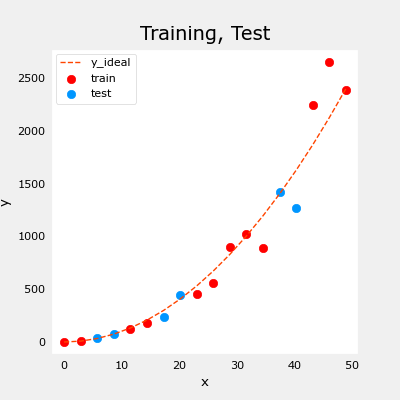

In [3]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="2.2"></a>
### 2.2 Cálculo del error para la evaluación del modelo, regresión lineal
Al *evaluar* un modelo de regresión lineal, se promedia la diferencia de error al cuadrado de los valores predichos y los valores objetivo.

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

<a name="ex01"></a>
### Ejercicio 1

A continuación, cree una función para evaluar el error en un conjunto de datos para un modelo de regresión lineal.

In [4]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse(y, yhat):
    """ 
    Calcula el error medio cuadrático de un conjunto de datos.
    Args:
      y : (ndarray Shape (m,) o (m,1)) valor objetivo de cada ejemplo
      yhat : (ndarray Shape (m,) o (m,1)) valor predicho de cada ejemplo
    Devuelve:
      err: (escalar)          
    """
    m = len(y)
    err = 0.0
    for i in range(m):
    ### START CODE HERE ### 
        err_i = (( yhat[i] - y[i] ) ** 2) 
        err  += err_i                                                                
    err = err / (2*m)  
    ### END CODE HERE ### 
    
    return(err)

In [5]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)   
# END UNIT TEST

 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

    
```python
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
    err = err / (2*m)                    
    return(err)
``` 

<a name="2.3"></a>
### 2.3 Comparar el rendimiento en los datos de entrenamiento y de prueba
Vamos a construir un modelo polinómico de alto grado para minimizar el error de entrenamiento. Para ello utilizaremos las funciones linear_regression de `sklearn`. El código está en el archivo de la utilidad importada si desea ver los detalles. Los pasos a seguir son:
* crear y ajustar el modelo. ('fit' es otro nombre para entrenar o ejecutar el descenso de gradiente).
* Calcular el error en los datos de entrenamiento.
* Calcular el error en los datos de prueba.

In [6]:
# crear un modelo en sklearn, entrenar con los datos de entrenamiento
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predecir sobre los datos de entrenamiento, encontrar el error de entrenamiento
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predecir en datos de prueba, encontrar el error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

El error calculado en el conjunto de entrenamiento es sustancialmente menor que el del conjunto de prueba. 

In [7]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


El siguiente gráfico muestra el motivo. El modelo se ajusta muy bien a los datos de entrenamiento. Para ello, ha creado una función compleja. Los datos de prueba no formaban parte del entrenamiento y el modelo hace un mal trabajo de predicción en estos datos.  
Este modelo se describiría como: 1) se ajusta en exceso, 2) tiene una alta varianza 3) "generaliza" mal.

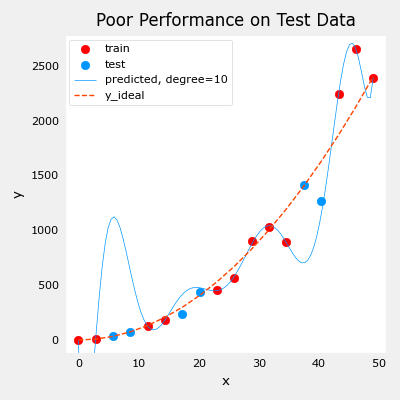

In [8]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

El error del conjunto de pruebas muestra que este modelo no funcionará bien con datos nuevos. Si se utiliza el error de la prueba para orientar las mejoras del modelo, éste funcionará bien con los datos de la prueba... pero los datos de la prueba estaban destinados a representar los *nuevos* datos.
Se necesita otro conjunto de datos para probar el rendimiento de los nuevos datos.

La propuesta hecha durante la conferencia es separar los datos en tres grupos. La distribución de los conjuntos de entrenamiento, validación cruzada y prueba que se muestra en la siguiente tabla es una distribución típica, pero puede variarse en función de la cantidad de datos disponibles.

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Datos utilizados para ajustar los parámetros del modelo $w$ y $b$ en el entrenamiento o ajuste |
| cross-validation | 20         | Datos utilizados para ajustar otros parámetros del modelo como el grado del polinomio, la regularización o la arquitectura de una red neuronal.|
| test             | 20         | Datos utilizados para probar el modelo después del ajuste para medir el rendimiento en los nuevos datos |


Vamos a generar tres conjuntos de datos a continuación. Una vez más usaremos `train_test_split` de `sklearn` pero lo llamaremos dos veces para obtener tres splits:

In [9]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


<a name="3"></a>
## 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> 
 Arriba, estaba claro que el grado del modelo polinómico era demasiado alto. ¿Cómo se puede elegir un buen valor? Resulta que, como se muestra en el diagrama, el rendimiento del entrenamiento y la validación cruzada pueden servir de orientación. Probando un rango de valores de grado, se puede evaluar el rendimiento del entrenamiento y de la validación cruzada. A medida que el grado se hace demasiado grande, el rendimiento de validación cruzada comenzará a degradarse en relación con el rendimiento de entrenamiento. Probemos esto en nuestro ejemplo.

<a name="3.1"></a>
### 3.1 Trazar el entrenamiento, la validación cruzada y la prueba
A continuación puede ver que los puntos de datos que formarán parte del entrenamiento (en rojo) están entremezclados con aquellos en los que el modelo no está entrenado (test y cv).

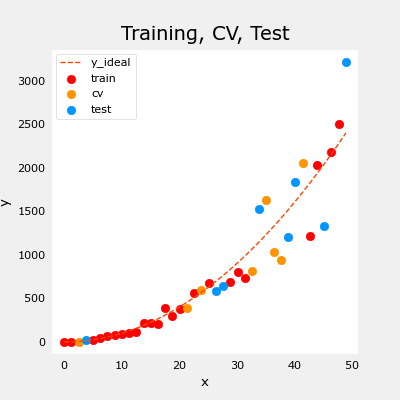

In [10]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="3.2"></a>
### 3.2 Encontrar el grado óptimo
En los laboratorios anteriores, usted descubrió que podía crear un modelo capaz de ajustar curvas complejas utilizando un polinomio (Ver Curso1, Semana2 Ingeniería de Características y Laboratorio de Regresión Polinomial).  Además, demostró que al aumentar el *grado* del polinomio, podría *crear* un sobreajuste. (Ver Curso 1, Semana 3, Laboratorio de sobreajuste). Utilicemos este conocimiento para probar nuestra capacidad de distinguir entre el sobreajuste y el infraajuste.

Vamos a entrenar el modelo repetidamente, aumentando el grado del polinomio en cada iteración. Aquí, vamos a utilizar el modelo de regresión lineal de [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) para la velocidad y la simplicidad.

In [11]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

<font size="4">Let's plot the result:</font>

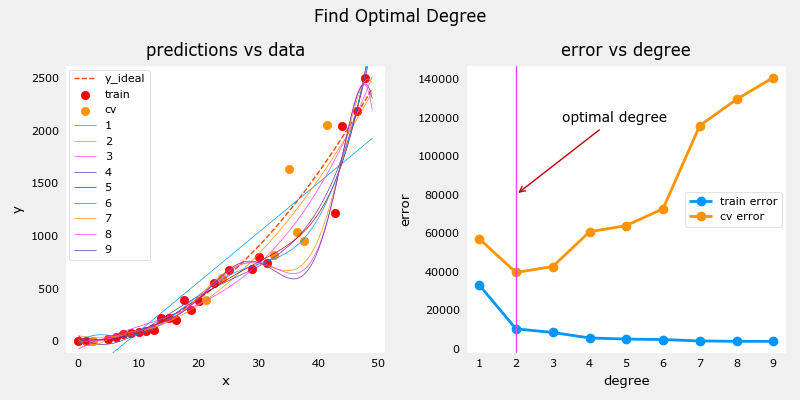

In [12]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

El gráfico anterior demuestra que la separación de los datos en dos grupos, los datos en los que se ha entrenado el modelo y los datos en los que no se ha entrenado, puede utilizarse para determinar si el modelo se está ajustando de forma insuficiente o excesiva. En nuestro ejemplo, hemos creado una variedad de modelos que varían desde el infraajuste hasta el sobreajuste aumentando el grado del polinomio utilizado. 
- En el gráfico de la izquierda, las líneas continuas representan las predicciones de estos modelos. Un modelo polinómico de grado 1 produce una línea recta que se cruza con muy pocos puntos de datos, mientras que el grado máximo se acerca mucho a todos los puntos de datos. 
- A la derecha
    - el error en los datos entrenados (azul) disminuye a medida que aumenta la complejidad del modelo, como era de esperar
    - el error de los datos de validación cruzada disminuye inicialmente a medida que el modelo empieza a ajustarse a los datos, pero luego aumenta a medida que el modelo empieza a sobreajustarse a los datos de entrenamiento (no consigue *generalizar*).     
    
Cabe destacar que las curvas de estos ejemplos no son tan suaves como las que se podrían dibujar para una conferencia. Está claro que los puntos de datos específicos asignados a cada grupo pueden cambiar significativamente sus resultados. Lo importante es la tendencia general.

<a name="3.3"></a>
### 3.3 Ajuste de la regularización.
En los laboratorios anteriores, se ha utilizado la *regularización* para reducir el sobreajuste. Al igual que con el grado, se puede utilizar la misma metodología para ajustar el parámetro de regularización lambda ($\lambda$).

Vamos a demostrar esto comenzando con un polinomio de alto grado y variando el parámetro de regularización.

In [13]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

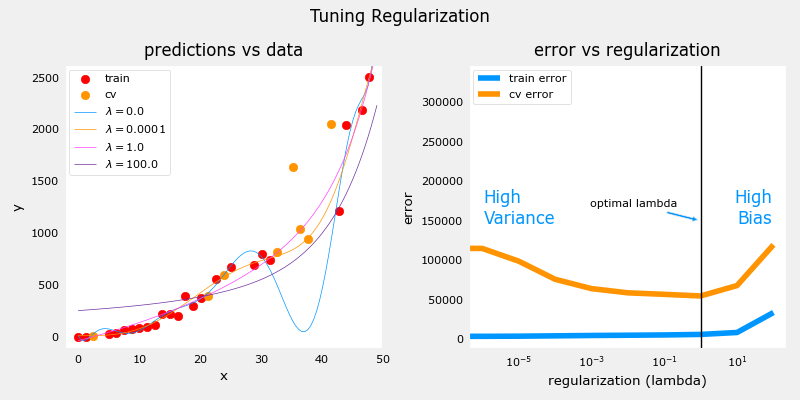

In [14]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Arriba, los gráficos muestran que a medida que aumenta la regularización, el modelo pasa de ser un modelo de alta varianza (sobreajuste) a un modelo de alto sesgo (infraajuste). La línea vertical del gráfico de la derecha muestra el valor óptimo de lambda. En este ejemplo, el grado polinómico se fijó en 10. 

<a name="3.4"></a>
### 3.4 Obtener más datos: Aumentar el tamaño del conjunto de entrenamiento (m)
Cuando un modelo está sobreajustado (alta varianza), recoger datos adicionales puede mejorar el rendimiento. Intentémoslo aquí.

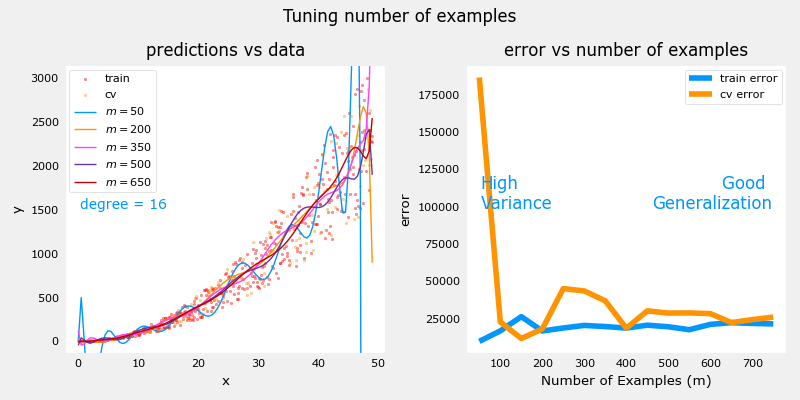

In [15]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

Los gráficos de arriba muestran que cuando un modelo tiene una varianza alta y está sobreajustado, añadir más ejemplos mejora el rendimiento. Observe las curvas del gráfico de la izquierda. La curva final con el valor más alto de $m$ es una curva suave que está en el centro de los datos. A la derecha, a medida que aumenta el número de ejemplos, el rendimiento del conjunto de entrenamiento y del conjunto de validación cruzada convergen a valores similares. Obsérvese que las curvas no son tan suaves como podría verse en una conferencia. Eso es de esperar. La tendencia sigue siendo clara: más datos mejoran la generalización. 

> Obsérvese que añadir más ejemplos cuando el modelo tiene un sesgo elevado (infraajuste) no mejora el rendimiento.


<a name="4"></a>
## 4 - Evaluación de un algoritmo de aprendizaje (red neuronal)
Anteriormente, usted afinó aspectos de un modelo de regresión polinómica. Aquí, usted trabajará con un modelo de red neuronal. Empecemos por crear un conjunto de datos de clasificación. 

<a name="4.1"></a>
### 4.1 Conjunto de datos
Ejecute la celda siguiente para generar un conjunto de datos y dividirlo en conjuntos de entrenamiento, validación cruzada (CV) y prueba. En este ejemplo, aumentamos el porcentaje de puntos de datos de validación cruzada para dar énfasis.   

In [16]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


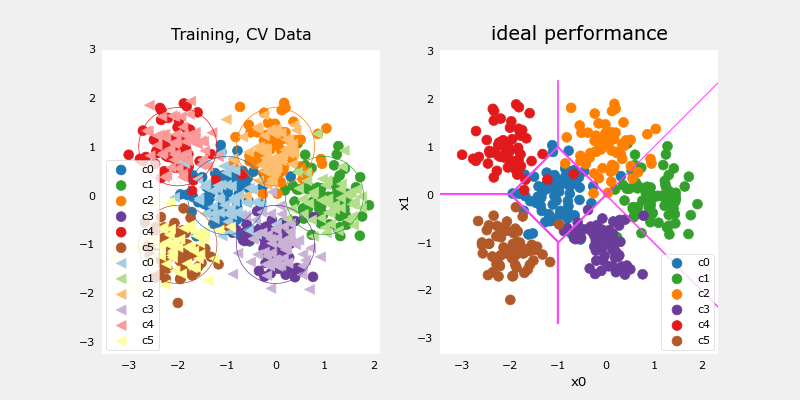

In [17]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Arriba, puede ver los datos a la izquierda. Hay seis clusters identificados por colores. Se muestran tanto los puntos de entrenamiento (puntos) como los de validación cruzada (triángulos). Los puntos interesantes son los que caen en lugares ambiguos en los que cualquiera de los dos clusters podría considerarlos miembros. ¿Qué esperarías que hiciera un modelo de red neuronal? ¿Cuál sería un ejemplo de sobreajuste o de infraajuste?  
A la derecha hay un ejemplo de un modelo "ideal", o un modelo que uno podría crear conociendo el origen de los datos. Las líneas representan límites de "igual distancia" en los que la distancia entre los puntos centrales es igual. Cabe señalar que este modelo "clasificaría mal" aproximadamente el 8% del conjunto de datos.

<a name="4.2"></a>
### 4.2 Evaluación del modelo categórico mediante el cálculo del error de clasificación
La función de evaluación de los modelos categóricos utilizada aquí es simplemente la fracción de predicciones incorrectas:  

$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

<a name="ex02"></a>
### ejercicio 2

A continuación, complete la rutina para calcular el error de clasificación. Tenga en cuenta que, en este laboratorio, los valores de los objetivos son el índice de la categoría y no están [codificados en un punto] (https://en.wikipedia.org/wiki/One-hot).

In [18]:
# UNQ_C2
# GRADED CELL: eval_cat_err
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
    ### START CODE HERE ### 
        if yhat[i] != y[i]:
            incorrect += 1
    cerr = incorrect/m     
    ### END CODE HERE ### 
    
    return(cerr)

In [19]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST
# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.
 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    return(cerr)                                    
``` 

<a name="5"></a>
## 5 - Complejidad del modelo
A continuación, construirá dos modelos. Un modelo complejo y un modelo simple. Evaluará los modelos para determinar si es probable que se ajusten en exceso o en defecto.

###  5.1 Complex model

<a name="ex03"></a>
### A continuación, componga un modelo de tres capas:
* Capa densa con 120 unidades, activación relu
* Capa densa con 40 unidades, activación relu
* Capa densa con 6 unidades y una activación lineal (no softmax)  
Compilar utilizando
* pérdida con `SparseCategoricalCrossentropy`, recuerde usar `from_logits=True`.
* Optimizador Adam con tasa de aprendizaje de 0,01.

In [20]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ### 
      Dense(120, activation = 'relu', name = "L1"),      
      Dense(40, activation = 'relu', name = "L2"),         
      Dense(classes, activation = 'linear', name = "L3")
        ### END CODE HERE ### 

    ], name="Complex"
)

In [21]:
model.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    ### END CODE HERE ### 
)

In [22]:
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 2s 7ms/step - loss: 1.1106
Epoch 2/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.4281
Epoch 3/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.3345
Epoch 4/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.2896
Epoch 5/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.2867
Epoch 6/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.2918
Epoch 7/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.2497
Epoch 8/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.2298
Epoch 9/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.2307
Epoch 10/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.2071
Epoch 11/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.2115
Epoch 12/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.2070
Epoch 13/1000
13/13 [====

In [23]:
# BEGIN UNIT TEST
model.summary()

model_test(model, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 120)               360       
                                                                 
 L2 (Dense)                  (None, 40)                4840      
                                                                 
 L3 (Dense)                  (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Complex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")  
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          
    optimizer=tf.keras.optimizers.Adam(0.01),   
)

model.fit(
    X_train,y_train,
    epochs=1000
)                                  
``` 

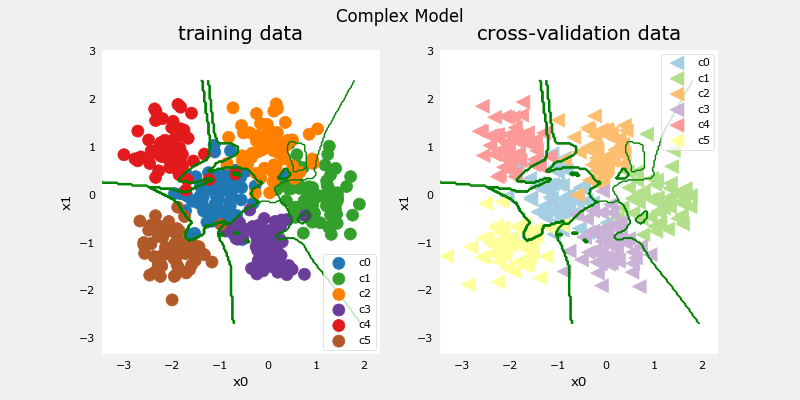

In [24]:
#hacer un modelo para llamar a las rutinas de trazado
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

Este modelo se ha esforzado por capturar los valores atípicos de cada categoría. Como resultado, ha clasificado mal algunos de los datos de validación cruzada. Calculemos el error de clasificación.

In [25]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

categorization error, training, complex model: 0.005
categorization error, cv,       complex model: 0.113


<a name="5.1"></a>
### 5.1 Modelo simple
Ahora, vamos a probar un modelo simple

<a name="ex04"></a>
### Ejercicio 4

A continuación, componga un modelo de dos capas:
* Capa densa con 6 unidades, activación relu
* Capa densa con 6 unidades y una activación lineal. 
Compilar utilizando
* pérdida con `SparseCategoricalCrossentropy`, recuerda usar `from_logits=True`
* Optimizador Adam con tasa de aprendizaje de 0,01.

In [26]:
# UNQ_C4
# GRADED CELL: model_s

tf.random.set_seed(1234)
model_s = Sequential(
    [
        ### START CODE HERE ### 
      Dense(6, activation = 'relu', name="L1"),
      Dense(classes, activation = 'linear', name="L2") 
        ### END CODE HERE ### 
    ], name = "Simple"
)
model_s.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    ### START CODE HERE ### 
)


In [27]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 1s 6ms/step - loss: 1.7306
Epoch 2/1000
13/13 [==============================] - 0s 7ms/step - loss: 1.4468
Epoch 3/1000
13/13 [==============================] - 0s 7ms/step - loss: 1.2902
Epoch 4/1000
13/13 [==============================] - 0s 7ms/step - loss: 1.1367
Epoch 5/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.9710
Epoch 6/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.7947
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6499
Epoch 8/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.5378
Epoch 9/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4652
Epoch 10/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4184
Epoch 11/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3860
Epoch 12/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3641
Epoch 13/1000
13/13 [====

In [28]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 6)                 18        
                                                                 
 L2 (Dense)                  (None, 6)                 42        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 6)                 18        
_________________________________________________________________
L2 (Dense)                   (None, 6)                 42        
=================================================================
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation = 'relu', name="L1"),            # @REPLACE
        Dense(classes, activation = 'linear', name="L2")     # @REPLACE
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),     # @REPLACE
)

model_s.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

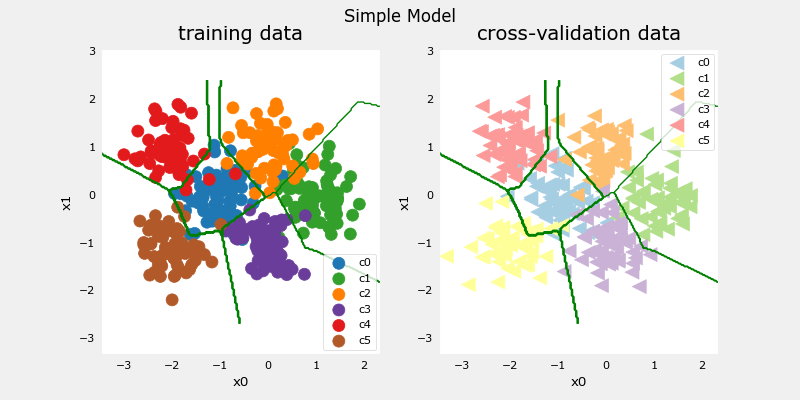

In [29]:
#hacer un modelo para llamar a las rutinas de trazado
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

Este sencillo modelo lo hace bastante bien. Calculemos el error de clasificación.

In [30]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

categorization error, training, simple model, 0.062, complex model: 0.005
categorization error, cv,       simple model, 0.087, complex model: 0.113


Nuestro modelo simple tiene un error de clasificación un poco más alto en los datos de entrenamiento, pero lo hace mejor en los datos de validación cruzada que el modelo más complejo.

<a name="6"></a>
## 6 - Regularización
Como en el caso de la regresión polinómica, se puede aplicar la regularización para moderar el impacto de un modelo más complejo. Probemos esto a continuación.

<a name="ex05"></a>
### Exercise 5

Reconstruya su modelo complejo, pero esta vez incluya la regularización.
A continuación, componga un modelo de tres capas:
* Capa densa con 120 unidades, activación relu, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Capa densa con 40 unidades, activación relu, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Capa densa con 6 unidades y una activación lineal. 
Compilar con
* pérdida con `SparseCategoricalCrossentropy`, recuerda usar `from_logits=True`.
* Optimizador Adam con tasa de aprendizaje de 0.01.

In [31]:
# UNQ_C5
# GRADED CELL: model_r

tf.random.set_seed(1234)
model_r = Sequential(
    [
        ### START CODE HERE ### 
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")
        ### START CODE HERE ### 
    ], name= None
)
model_r.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    ### START CODE HERE ### 
)


In [32]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 2s 8ms/step - loss: 4.4464
Epoch 2/1000
13/13 [==============================] - 0s 8ms/step - loss: 1.7086
Epoch 3/1000
13/13 [==============================] - 0s 8ms/step - loss: 1.3465
Epoch 4/1000
13/13 [==============================] - 0s 8ms/step - loss: 1.0870
Epoch 5/1000
13/13 [==============================] - 0s 8ms/step - loss: 1.0137
Epoch 6/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.9718
Epoch 7/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.9481
Epoch 8/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.8934
Epoch 9/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.8171
Epoch 10/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.7715
Epoch 11/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.7611
Epoch 12/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.7521
Epoch 13/1000
13/13 [====

In [33]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 120)               360       
                                                                 
 L2 (Dense)                  (None, 40)                4840      
                                                                 
 L3 (Dense)                  (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
ddd
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "ComplexRegularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")  
    ], name="ComplexRegularized"
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.01),                             
)

model_r.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

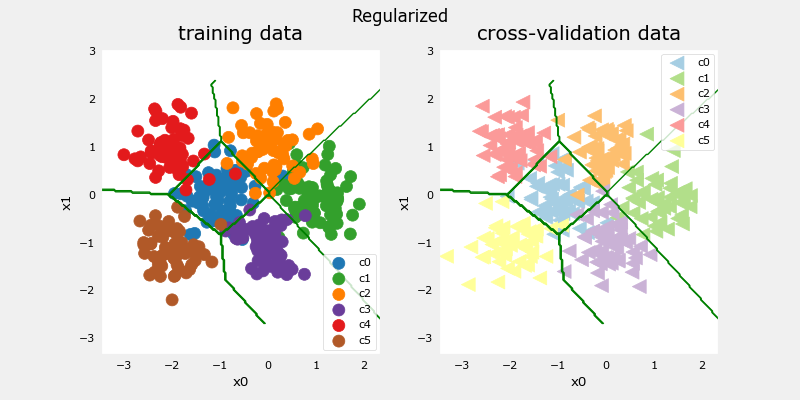

In [34]:
#hacer un modelo para llamar a las rutinas de trazado
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

Los resultados son muy similares al modelo "ideal". Comprobemos el error de clasificación.

In [35]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

categorization error, training, regularized: 0.072, simple model, 0.062, complex model: 0.005
categorization error, cv,       regularized: 0.066, simple model, 0.087, complex model: 0.113


The simple model is a bit better in the training set than the regularized model but it worse in the cross validation set.

<a name="7"></a>
## 7 - Iterar para encontrar el valor óptimo de regularización
Al igual que en la regresión lineal, puede probar muchos valores de regularización. Este código tarda varios minutos en ejecutarse. Si tienes tiempo, puedes ejecutarlo y comprobar los resultados. Si no, ¡has completado las partes calificadas de la tarea!

In [ ]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 [==============================] - 1s 4ms/step - loss: 1.1106
Epoch 2/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4281
Epoch 3/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3345
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2896
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2867
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2918
Epoch 7/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2497
Epoch 8/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2298
Epoch 9/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2307
Epoch 10/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2071
Epoch 11/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2115
Epoch 12/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2070
Epoch 13/1000
13/13 [====

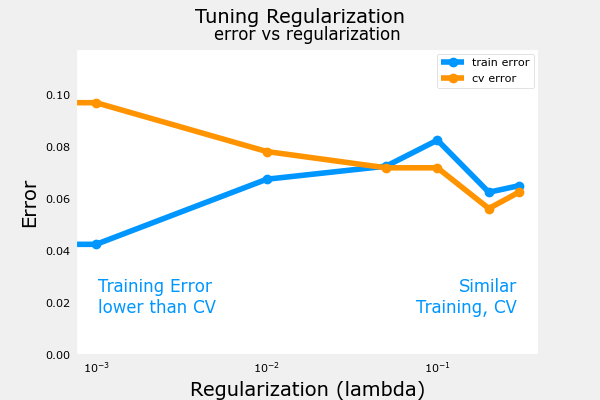

In [39]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

A medida que se aumenta la regularización, el rendimiento del modelo en los conjuntos de datos de entrenamiento y de validación cruzada converge. Para este conjunto de datos y modelo, lambda > 0,01 parece ser una opción razonable.

<a name="7.1"></a>
### 7.1 Prueba
Probemos nuestros modelos optimizados en el conjunto de pruebas y comparémoslos con el rendimiento "ideal". 

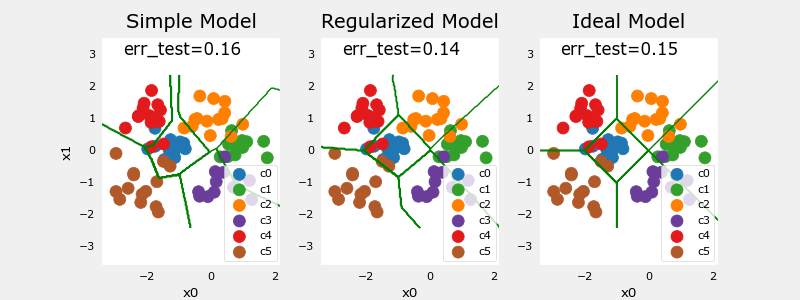

In [40]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

Nuestro conjunto de pruebas es pequeño y parece tener un número de valores atípicos, por lo que el error de clasificación es alto. Sin embargo, el rendimiento de nuestros modelos optimizados es comparable al rendimiento ideal.

## ¡Enhorabuena! 
Se ha familiarizado con importantes herramientas que debe aplicar al evaluar sus modelos de aprendizaje automático. A saber:  
* La división de los datos en conjuntos entrenados y no entrenados le permite diferenciar entre el ajuste insuficiente y el ajuste excesivo.
* La creación de tres conjuntos de datos, entrenamiento, validación cruzada y prueba, le permite
    * entrenar sus parámetros $W,B$ con el conjunto de entrenamiento
    * ajustar los parámetros del modelo, como la complejidad, la regularización y el número de ejemplos, con el conjunto de validación cruzada
    * Evaluar el rendimiento en el "mundo real" con el conjunto de pruebas.
* La comparación del rendimiento del entrenamiento con el de la validación cruzada permite conocer la propensión de un modelo a la sobreadaptación (alta varianza) o a la inadaptación (alto sesgo).